In [2]:
import torch
import yaml
from attrdict import AttrDict
from model import SPCC
from Dataset import Spcc_Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# load config
with open(r'./configs/SPCC_movie.yaml', 'r', encoding='utf-8') as f:
    cfg = yaml.safe_load(f)
args = AttrDict(cfg)


# load train dataset、Cur_dataset
dataset=Spcc_Dataset(args)
train_loader=DataLoader(
                        dataset=dataset,
                        batch_size=args.basic.batch_size,
                        shuffle=True,
                        num_workers=args.basic.num_workers,
                        drop_last=False)

# load model
model = SPCC(dataset.user_num, 
            dataset.item_num, 
            dataset.train_user_item,
            dataset.UserItemNet,
            args)



Loading data
user_num: 6040, item_num: 3706
train_interaction_num: 801633
Contructing UserItemNet for accelerating get relation...


In [4]:
train_data=dataset.train_user_item
print(len(train_data[655]))
print(len(train_data[34]))
print(len(train_data[4587]))
print(len(train_data[1285]))

143
161
39
55


In [3]:
dataset.train_data_np.shape[0]

1603266

In [6]:

# load model parameters
model.load_state_dict(torch.load(r'./ckpt/SPCC_movie_0/Epoch_79.pkl'))

model.to(args.basic.device)

SPCC(
  (Puser_lookup): Embedding(6040, 32)
  (Pitem_lookup): Embedding(3706, 32)
  (Puser_mlp): Sequential(
    (user_mlp_0): Linear(in_features=32, out_features=32, bias=True)
    (user_mlp_1): Linear(in_features=32, out_features=32, bias=True)
    (user_mlp_2): Linear(in_features=32, out_features=32, bias=True)
  )
  (Pitem_mlp): Sequential(
    (item_mlp_0): Linear(in_features=32, out_features=32, bias=True)
    (item_mlp_1): Linear(in_features=32, out_features=32, bias=True)
    (item_mlp_2): Linear(in_features=32, out_features=32, bias=True)
  )
  (Sitem_lookup): Embedding(3706, 32)
  (Suser_lookup): Embedding(6040, 32)
  (att): Linear(in_features=32, out_features=32, bias=True)
  (loss_function): BCEWithLogitsLoss()
  (Huber_loss): SmoothL1Loss()
)

In [7]:
## test
model._get_relation()


In [8]:
user_id=np.arange(dataset.user_num)
batch_user=user_id[:354]

prediction,scores_s=model.test(torch.from_numpy(batch_user).long().to(args.basic.device))

# P_s=prediction.cpu().detach().numpy()
# S_s=scores_s.cpu().detach().numpy()

# 对预测得分sigmoid
P_scores=torch.sigmoid(prediction).cpu().detach().numpy()
S_scores=torch.sigmoid(scores_s).cpu().detach().numpy()

user_id:34


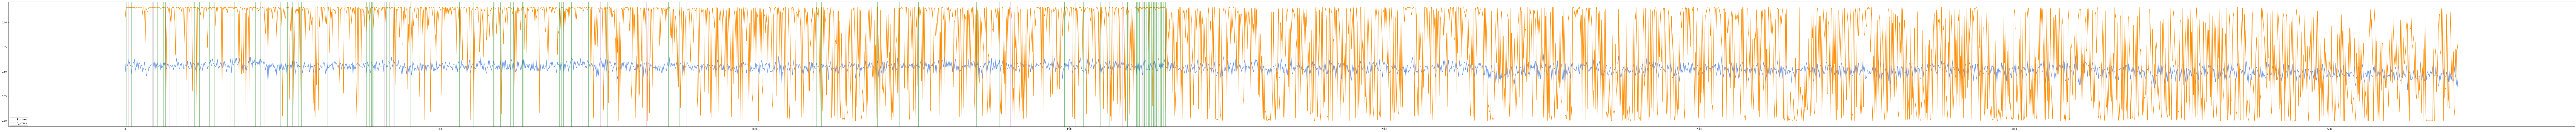

In [9]:
index=34
user_id=batch_user[index]
print(f"user_id:{user_id}")

test_positive_item=list(dataset.test_user_item[user_id])
train_positive_item=list(dataset.train_user_item[user_id])

# 把训练集出现的正样本item得分设置为0
# P_scores[index][train_positive_item]=0
# S_scores[index][train_positive_item]=0

plt.figure(figsize=(200,10))
plt.plot(P_scores[index],color='cornflowerblue',label='P_scores')
plt.plot(S_scores[index],color='darkorange',label='S_scores')
# plt.plot(P_scores[index]+S_scores[index],color='fuchsia',label='P+S scores')
# plt.plot(np.abs(P_scores[index]-S_scores[index]),color='black',label='P-S scores')
# plt.plot(1/np.abs(P_scores[index]-S_scores[index]),color='blue',label='1/(P-S) scores')
# plt.plot(P_scores[index]*np.log(P_scores[index]/S_scores[index]),color='silver',label='Plog(P/S) scores')
# plt.plot(S_scores[index]*np.log(S_scores[index]/P_scores[index]),color='peru',label='Slog(S/P) scores')

for x in test_positive_item:# 直接画一条竖线，标记测试集样本
    plt.axvline(x,linewidth=0.5,linestyle='-', color='plum')
for x in train_positive_item:# 直接画一条竖线，标记训练集样本
    plt.axvline(x,linewidth=0.5,linestyle='-', color='g')

# 标记出P_scores里测试集正样本和训练集正样本的点
# plt.plot(test_positive_item,P_scores[index][test_positive_item],"ro",label='Test_P_scores')
# plt.plot(train_positive_item,P_scores[index][train_positive_item],"rx",label='Train_P_scores')

# 标记出S_scores里测试集正样本和训练集正样本的点
# plt.plot(test_positive_item,S_scores[index][test_positive_item],"g+",label='Test_S_scores')
# plt.plot(train_positive_item,S_scores[index][train_positive_item],"g*",label='Train_S_scores')

plt.legend(loc = 'lower left')

<AxesSubplot:ylabel='Count'>

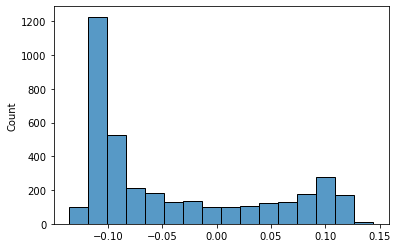

In [10]:
# 画出刺激值的分布

import seaborn as sns
import matplotlib.pyplot as plt

Sti_p_center_list=P_scores[index]*np.log(P_scores[index]/S_scores[index])
# sns.histplot([1 if i >=0.05 else 0 for i in hitRate_list])
sns.histplot(Sti_p_center_list)

<AxesSubplot:ylabel='Count'>

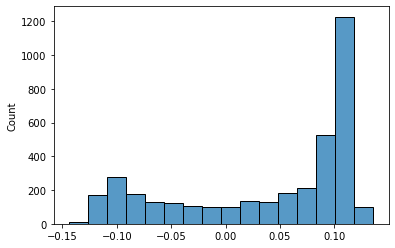

In [11]:
Sti_s_center_list=P_scores[index]*np.log(S_scores[index]/P_scores[index])
sns.histplot(Sti_s_center_list)

[-2.2351742e-08 -2.9802322e-08 -7.4505806e-09 ...  1.4901161e-08
  7.4505806e-09 -1.1175871e-08]


<AxesSubplot:ylabel='Count'>

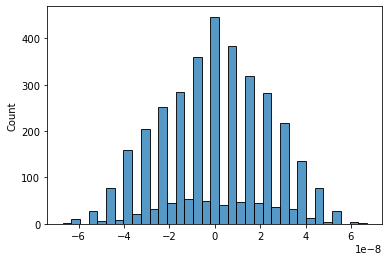

In [12]:
sum_Sti=Sti_s_center_list+Sti_p_center_list
print(sum_Sti)
sns.histplot(sum_Sti)

Text(0.5, 0, 'Stimulation')

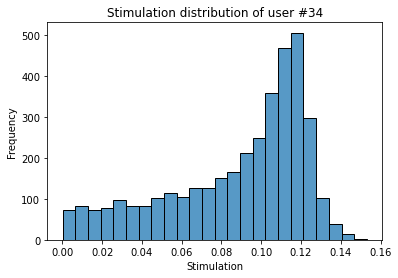

In [13]:
Sti_sub_list=np.abs(P_scores[index]-S_scores[index])
sns.histplot(Sti_sub_list)
plt.title('Stimulation distribution of user #34')
plt.ylabel('Frequency')
plt.xlabel('Stimulation')

median:0.10049408674240112
mean:0.08811908960342407
std:0.03496918827295303


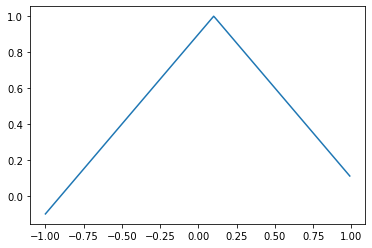

In [14]:

median=np.median(Sti_sub_list)
mean=np.mean(Sti_sub_list)
std=np.std(Sti_sub_list)
print(f'median:{median}')
print(f"mean:{mean}")
print(f"std:{std}")
pseudo_label=1-np.abs(np.arange(-1,1,0.01)-median)
plt.plot(np.arange(-1,1,0.01),pseudo_label)

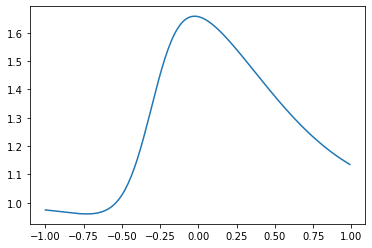

In [15]:
import matplotlib.pyplot as plt
import numpy as np
def Cur(sti, median, slope_r, slope_p, offset,bias):
    R=1/(1+np.exp(-slope_r*(sti+(offset-median))))
    P=1/(1+np.exp(slope_p*(sti-(median+offset))))
    Cur_scores=R+P+bias
    return Cur_scores
median=0.0066
mean=0.138
std=0.1910
a=1.3
x=np.arange(-1,1,0.01)
# y=Cur(x,median,10*(median),10*(1-median),1-std,0)
y=Cur(x,median,10*np.exp(-a*(median)),10*np.exp(-a*(1-median)),0.5-std,0)
plt.plot(x,y)

median:0.3381347060203552, mean:0.3581414520740509, std:0.23795537650585175


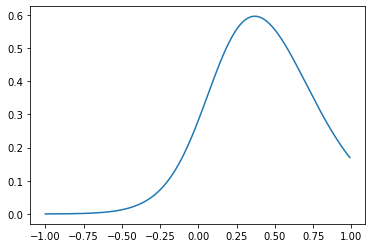

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def Cur_compute(sti, median, slope_r, slope_p, offset,bias):
    R=1/(1+np.exp(-slope_r*(sti+(offset-median))))
    P=1/(1+np.exp(slope_p*(sti-(median+offset))))
    Cur_scores=R+P+bias
    return Cur_scores

# 根据Cur模块的参数画图
para_path='./ckpt/SPCC_movie_1/Cur_para.pkl.npy'
user_id=57
para_lookup=np.load(para_path)

alpha=1.3
bias=-1
median=para_lookup[user_id][0]
mean=para_lookup[user_id][1]
std=para_lookup[user_id][2]
print(f"median:{median}, mean:{mean}, std:{std}")

x=np.arange(-1,1,0.01)
y=Cur_compute(x,mean,10*np.exp(-alpha*(median)),10*np.exp(-alpha*(1-median)),0.5-std,bias)
plt.plot(x,y)


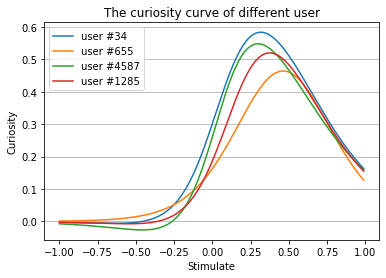

In [7]:
def Plot(x,y):
    plt.plot(x,y)
    plt.show()
    plt.clf()
    plt.close()

user_list=[34,655,4587,1285]
for user_id in user_list:
    median=para_lookup[user_id][0]
    mean=para_lookup[user_id][1]
    std=para_lookup[user_id][2]
    x=np.arange(-1,1,0.01)  
    y=Cur_compute(x,mean,10*np.exp(-alpha*(median)),10*np.exp(-alpha*(1-median)),0.5-std,bias)
    # Plot(x,y)
    plt.plot(x,y)
    plt.xlabel('Stimulate')
    plt.ylabel('Curiosity')
plt.title('The curiosity curve of different user')
plt.legend(['user #34','user #655','user #4587','user #1285'])
plt.grid(axis='y')
plt.savefig('./cur.png')